In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import glob
from scipy import optimize
from scipy.special import erf
import os
import numpy.polynomial.polynomial as poly
from scipy.stats import chisquare
from collections import OrderedDict


In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def FIND_MAX(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+5
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    maxy = max(yyy)
    
    hold      = find_nearest(yyy,maxy)
    peak     = np.where(yyy==hold)[0][0]

    xxx = xx[Trigger:Trigger+peak]
    yyy = yy[Trigger:Trigger+peak]
    
    hold      = find_nearest(yyy,maxy*0.1)
    edge     = np.where(yyy==hold)[0][0]
    return Trigger+peak, Trigger+edge

def FIND_MIN(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    miny = min(yyy)
    
    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]
    
    TT = Trigger+MINLOC
    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]
    
    hold      = find_nearest(yyyy,miny*0.1)
    REDGE     = np.where(yyyy==hold)[0][0]
    return MINLOC+Trigger,miny,REDGE+Trigger

In [4]:
def funcG(t,t0,sig,a,c):
    tau = 121e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def funcA(t,t0,sig,a,c):
    tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

In [5]:
def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-100
    fitX = XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-cut2:Arr+cut]
    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcG(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

In [6]:
def FITTER_ANOD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-50
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]


    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

In [7]:
def gaus(x,x0,sigma,a,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+c

In [63]:
PATH = '/Users/austinmcdonald/Desktop/XeAr/Data-3/'
#PATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'

folders = glob.glob(PATH+"*/")
folders.sort()
folders

['/Users/austinmcdonald/Desktop/XeAr/Data-3/000/',
 '/Users/austinmcdonald/Desktop/XeAr/Data-3/002/',
 '/Users/austinmcdonald/Desktop/XeAr/Data-3/008/',
 '/Users/austinmcdonald/Desktop/XeAr/Data-3/015/',
 '/Users/austinmcdonald/Desktop/XeAr/Data-3/035/',
 '/Users/austinmcdonald/Desktop/XeAr/Data-3/099/',
 '/Users/austinmcdonald/Desktop/XeAr/Data-3/100/']

In [64]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
CHIa = []
CHIg = []
for F in range(0,len(folders)):
    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    info = np.loadtxt(folders[F]+'Run-info.txt')
    files.remove('Run-info.txt')
    files.sort()
    for fi in files:
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(np.nan_to_num(Data[0]))!=0 and np.mean(np.nan_to_num(Data[1]))!=0:
            xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])
            CHIa.append(chia)
            CHIg.append(chig)
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            if PP==1:
                PP = info[0]
            elif PP==3:
                PP = info[1]
            elif PP==6:
                PP = info[2]
            elif PP==9:
                PP = info[3]
            elif PP==11 or PP==10:
                PP = info[4]
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
        
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct

Xe-000_P-01_E-060.txt
Xe-000_P-01_E-080.txt
Xe-000_P-01_E-100.txt
Xe-000_P-01_E-150.txt
Xe-000_P-01_E-200.txt
Xe-000_P-03_E-080.txt
Xe-000_P-03_E-100.txt
Xe-000_P-03_E-150.txt
Xe-000_P-03_E-200.txt
Xe-000_P-06_E-080.txt
Xe-000_P-06_E-100.txt
Xe-000_P-06_E-150.txt
Xe-000_P-06_E-200.txt
Xe-000_P-09_E-080.txt
Xe-000_P-09_E-100.txt
Xe-000_P-09_E-150.txt
Xe-000_P-09_E-200.txt
Xe-000_P-11_E-060.txt
Xe-000_P-11_E-080.txt
Xe-000_P-11_E-100.txt
Xe-000_P-11_E-150.txt
Xe-000_P-11_E-200.txt
Xe-002_P-01_E-080.txt
Xe-002_P-01_E-100.txt
Xe-002_P-01_E-150.txt
Xe-002_P-01_E-200.txt
Xe-002_P-03_E-080.txt
Xe-002_P-03_E-100.txt
Xe-002_P-03_E-150.txt
Xe-002_P-03_E-200.txt
Xe-002_P-06_E-080.txt
Xe-002_P-06_E-100.txt
Xe-002_P-06_E-150.txt
Xe-002_P-06_E-200.txt
Xe-002_P-09_E-080.txt
Xe-002_P-09_E-100.txt
Xe-002_P-09_E-150.txt
Xe-002_P-09_E-200.txt
Xe-002_P-11_E-080.txt
Xe-002_P-11_E-100.txt
Xe-002_P-11_E-150.txt
Xe-002_P-11_E-200.txt
Xe-008_P-01_E-080.txt
Xe-008_P-01_E-100.txt
Xe-008_P-01_E-150.txt
Xe-008_P-0

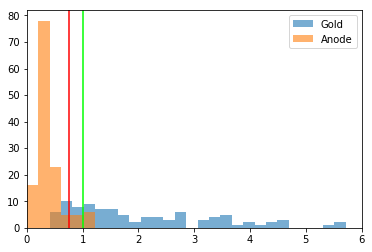

In [65]:
CHIa = np.array(CHIa)*1e6
CHIg = np.array(CHIg)*1e6
plt.hist(CHIg,bins=np.linspace(0,10,50),alpha=0.6,label="Gold")
plt.hist(CHIa,bins=np.linspace(0,10,50),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.xlim(0,6)
plt.axvline(0.75,color="r")
plt.axvline(1,color="lime")
plt.show()

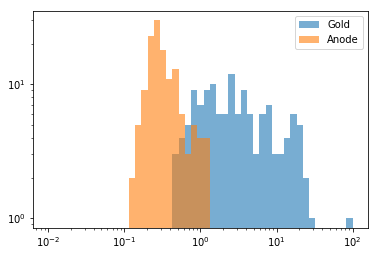

In [66]:
plt.hist(CHIg,bins=np.logspace(-2,2,50),alpha=0.6,label="Gold")
plt.hist(CHIa,bins=np.logspace(-2,2,50),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.loglog()
#plt.xlim(0,6)
#plt.axvline(0.75,color="r")
#plt.axvline(1,color="lime")
#plt.axvline(0.6,color="g")
#plt.axvline(0.8,color="b")
plt.show()

In [67]:
PERCT

{0: '000', 1: '002', 2: '008', 3: '015', 4: '035', 5: '099', 6: '100'}

In [68]:
def Dl(Redu, sigma, time):
    D  = sigma/(2*time)  
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlP(Redu, sigma, time,pre):
    D  = sigma/(2*time)#*pre  
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlS(Redu, sigma, time):
    d = 15.12
    D = (sigma*d**2)/(2*time**3)*1e6 # Dl slash
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlSstar(Redu, sigma, time, pre):
    d = 15.12
    d = 13.49
    D = (sigma*d**2)/(2.*time**3)*1e6 # Dl slash
    D = 2.*D/(d/(time*1e-6))
    D = np.sqrt(D)*np.sqrt(pre)
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlSP(Redu, sigma, time,pre):
    d = 15.12
    D = (sigma*d**2)/(2*time**3)*1e6*np.sqrt(pre) # Dl slash
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def Vel(Redu, time):
    d = 151.2
    D = d/time
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def Mark(Redu,pre):
    sort_index = np.argsort(Redu)
    ms = ['<','s','D','^','*','o']
    mark = np.rint(pre).astype(str)
    mark[mark == "1.0"]  = ms[0]
    mark[mark == "3.0"]  = ms[1]
    mark[mark == "6.0"]  = ms[2]
    mark[mark == "9.0"]  = ms[3]
    mark[mark == "10.0"] = ms[4]
    mark[mark == "11.0"] = ms[5]
    mark = mark[sort_index]
    return mark

In [69]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']

In [70]:
nextDX = np.array([22.9,25.9,26.2,28.0,28.3,28.4,29.9,33.2,34.0,37.9,38.0,38.3,42.0,43.4,44.4,47.5,48.6,53.7,57.0])
nextDY = np.array([1357.3, 1213.3, 1167.4, 1161.1, 1320.9, 1195.9, 1105.7, 1058.2, 1034.5, 979.1, 1129.4,
          988.6, 941.1, 939.6, 958.5, 1028.2, 901.6, 869.9, 903.2])
print(len(nextDX))
print(len(nextDY))

19
19


No handles with labels found to put in legend.


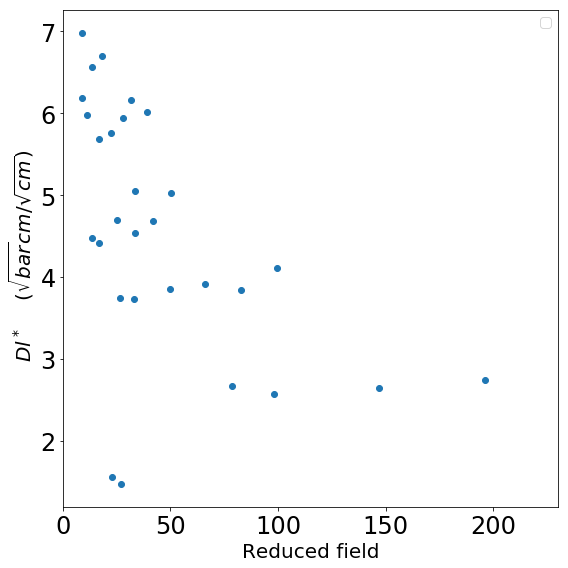

In [79]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [6]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2

    #sig = ((ANODE[q][:,1]*1e6))**2
    dd = 15.12*1e4
    DlErr  = 0.5*np.sqrt(6*(0.01)**2+3*(0.3/15.12)**2+(0.01/PRE[q])**2)
    X = REDU[q]#2*dd/(PRE[q]*REDU[q])#DlStar[q]
    ds = 15.12
    t = Dt
    #Y = dd**2/(2*Dt**3)*sig
    Y = (sig*ds**2)/(2*t**3)*1e6 # Dl slash
    DlSlash = Y
    Y = (DlSlash*1e8)
    #Y = ((sig*ds**2)/(2*t**3))/((ds/t)**2) # Dl slash/V**2
    #Y = (sig)/(2*Dt) # Dl
    #Y = sig
    #Y = Dt
    #ds = 151.2
    #Y = ds/t
    VVd = (15.12/Dt)*1e6

    Y = np.sqrt(2*Y/VVd)#*np.sqrt(PRE[q])#*np.sqrt(273/296)

    mark = Mark(REDU[q],PRE[q])
    X,Y = DlS(REDU[q],sig,Dt)
    #X,Y = Dl(REDU[q],sig,Dt)
    X,Y = DlP(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSP(REDU[q],sig,Dt,PRE[q])
    X,V = Vel(REDU[q],Dt)
    
    X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSstar(REDU[q],sig,Dt,1)
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    sig = ((GOLDD[q][:,1]*1e6))**2
    plt.scatter(REDU[q],sig)
    #plt.scatter(REDU[q],np.sqrt(PRE[q])/PRE[q])
    #plt.scatter(X,Y,label=lab,s=10,color=color,alpha=0.6)
    #sig = ((ANODE[q][:,1]*1e6))**2
    #X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    #plt.scatter(X,Y,label=lab,s=30,color='r',alpha=0.6)

    #plt.errorbar(X,Y/2,xerr=0,yerr=Y/2*0.1,ecolor=color,fmt='D', capthick=1,markersize=0)

    #for x, y, m in zip(X, Y, mark):
    #    plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,2*nextDY/1e4,color='lime')
#plt.errorbar(nextDX,nextDY/1e4,xerr=0,yerr=0.01,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')

#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)

plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [42]:
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2


In [61]:
np.mean((ANODE[0][:,1]*1e6)**2)

11.975579563428903

In [62]:
np.mean((GOLDD[0][:,1]*1e6)**2)

1.5304429440840446

In [74]:
np.mean((ANODE[0][:,1]*1e6)**2)

12.01053883948868

In [73]:
np.mean((ANODE[6][:,1]*1e6)**2)

81.29249988218403

In [75]:
np.mean((GOLDD[0][:,1]*1e6)**2)

1.5276097215585354

In [ ]:
np.mean((ANODE[0][:,1]*1e6)**2)

In [ ]:
np.mean((GOLDD[0][:,1]*1e6)**2)

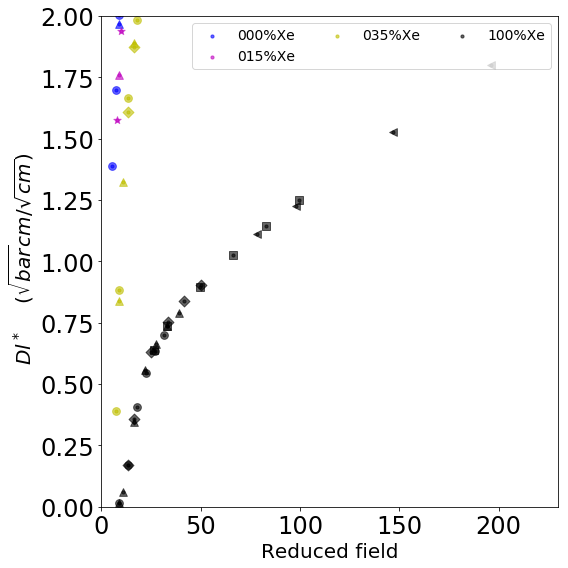

In [86]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0,3,4,6]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2



    mark = Mark(REDU[q],PRE[q])
    X,Y = DlS(REDU[q],sig,Dt)
    #X,Y = Dl(REDU[q],sig,Dt)
    X,Y = DlP(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSP(REDU[q],sig,Dt,PRE[q])
    X,V = Vel(REDU[q],Dt)
    
    X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSstar(REDU[q],sig,Dt,1)
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    #plt.scatter(REDU[q],np.sqrt(PRE[q])/PRE[q])
    plt.scatter(X,V**3,label=lab,s=10,color=color,alpha=0.6)
    for x, y, m in zip(X, V**3, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY/1e4,color='lime')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)
plt.ylim(0,2)
plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

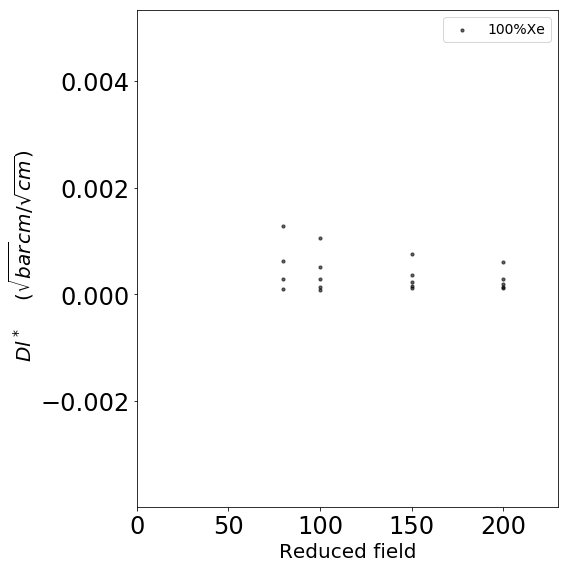

In [99]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [6]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2



    mark = Mark(REDU[q],PRE[q])
    X,Y = DlS(REDU[q],sig,Dt)
    #X,Y = Dl(REDU[q],sig,Dt)
    X,Y = DlP(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSP(REDU[q],sig,Dt,PRE[q])
    X,V = Vel(REDU[q],Dt)
    
    X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSstar(REDU[q],sig,Dt,1)
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    #plt.scatter(REDU[q],np.sqrt(PRE[q])/PRE[q])
    plt.scatter(EFID[q],15/Dt/EFID[q]/np.sqrt(PRE[q]),label=lab,s=10,color=color,alpha=0.6)
    #for x, y, m in zip(X, V**3, mark):
    #    plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY/1e4,color='lime')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)
#plt.ylim(0,2)
plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
PRE[q]

In [ ]:
np.sqrt(PRE[q])

In [ ]:
PRE[q]

In [ ]:
for x, y, c, m in zip(datas[:,0], datas[:,1], colors, markers)
    ax.scatter(x, y, alpha=0.8, c=c,marker=m) 

In [ ]:
x = [0,1,2]
y = [0,1,2]
m = ['<','s','D']
for x, y, m in zip(x, y, m):
    plt.scatter(x, y, alpha=0.8,marker=m) 

In [ ]:
np.rint(PRE[q])

In [81]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
for q in range(0,7):

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
    sig = ((ANODE[q][:,1]*1e6))**2
    #SigmaA.append(sig.tolist())

    #dd = 13.49*1e4
    dd = 15.12*1e4
    
    mu = Vd/EFID[q]
    X = REDU[q]#2*dd/(PRE[q]*REDU[q])#DlStar[q]
    ds = 15.12
    t = Dt
    #Y = dd**2/(2*Dt**3)*sig
    Y = (sig*ds**2)/(2*t**3)*1e6 # Dl slash
    DlSlash = Y
    Y = (DlSlash*1e8)
    #Y = ((sig*ds**2)/(2*t**3))/((ds/t)**2) # Dl slash/V**2
    #Y = (sig)/(2*Dt) # Dl
    #Y = sig
    #Y = Dt
    #ds = 151.2
    #Y = ds/t
    VVd = (15.12/Dt)*1e6

    Y = np.sqrt(2*Y/VVd)#*np.sqrt(PRE[q])#*np.sqrt(273/296)
    #sort_index = np.argsort(X)
    #X = X[sort_index]
    #Y = Y[sort_index]
    lab = PERCT[q]+'%Xe'
    plt.scatter(X,Y,label=lab)
    #DlErr  = 0.5*np.sqrt(6*(0.01)**2+3*(0.3/15.12)**2+(0.01/PRE[q])**2)
    #Yer = Y*0.1#DlErr
    #plt.errorbar(X,Y,yerr=Yer,fmt='none', capthick=1)
    
    #plt.plot(X,Y)
    #plt.plot(PRE[q],((GOLDD[q][:,1]*1e6))**2,'o')
    #plt.plot(PRE[q],((ANODE[q][:,1]*1e6))**2,'x')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)

plt.ylim(1200,2200)
#plt.ylim(0.025,1)
plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$ slash   ($\mu m / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTAR"+".png")
plt.show()

NameError: name 'Vd' is not defined

<Figure size 576x576 with 0 Axes>

In [ ]:
Y

In [ ]:
PERCT

In [ ]:
sig

In [ ]:
Y/(((ds/t)*1e6)**2)

In [ ]:
DlStar = dict()
DlSerr = dict()
Vel = dict()
VelErr=dict()
REDUerr=dict()
SigmaA = []
SigmaG = []
for q in range(0,len(GOLDD)):

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
    gig = ((GOLDD[q][:,1]*1e6))**2
    sig = ((ANODE[q][:,1]*1e6))**2
    SigmaA.append(sig.tolist())
    SigmaG.append(gig.tolist())
    #sig = ((ANODE[:,1]*1e6))**2 

    dd = 13.49*1e4
    dd = 15.12*1e4
    Dlong = sig*0.5*dd**2/Dt**3
    Dlong = sig*dd**2/Dt**3
    Vd = 15.12/Dt
    Vel[q] = 151.2/Dt
    VelErr[q]  = np.sqrt((0.3/15.12)**2+(0.01/PRE[q])**2)
    
    Dlstar = np.sqrt(2*Dlong/Vd)*np.sqrt(PRE[q])*np.sqrt(273/296)
    DlErr  = 0.5*np.sqrt(6*(0.01)**2+3*(0.3/15.12)**2+(0.01/PRE[q])**2)
    DlStar[q] = Dlstar
    DlSerr[q] = DlErr

In [ ]:
SigmaG = [item for sublist in SigmaG for item in sublist]
SigmaA = [item for sublist in SigmaA for item in sublist]

In [ ]:
bb = np.linspace(0,25,30)
plt.hist(SigmaG,bins=bb)
plt.show()


bb = np.linspace(0,1e3,30)
plt.hist(SigmaA,bins=bb)
plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)):
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'
    ax1.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    ax1.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

ax1.set_xscale('log')
ax1.set_xticks([7,10,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(6,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeArHe/MBV-Error-XeAr.npy")

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    ax1.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    ax1.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    ax1.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

    
ax1.set_xscale('log')
ax1.set_xticks([7,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(7,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
MBZ = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeAr-Dl.npy")

In [ ]:
len(MBZ)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
len(COL)

In [ ]:
len(GOLDD)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.scatter(REDU[q],DlStar[q],label=PERCT[q],color=COL[q])

    Yer = DlStar[q]*0.027655
    Yer = DlStar[q]*DlSerr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],DlStar[q],xerr=Xer,yerr=Yer,fmt='none', capthick=1,color=COL[q])

        
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)
    
    
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0.5e3,5e3)
plt.xlim(0,330)
plt.show()

In [ ]:
len(GOLDD)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in [0,4,6]:
   
    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=PERCT[q])
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)

plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,3500)
plt.xlim(0,330)
plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in [0,2,6]:
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)
    
    
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=22,ncol=1)

plt.ylim(400,2100)
plt.xlim(0,230)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/diff"+".png")

plt.show()

In [ ]:
len(DlStar[q]/2)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.figure(figsize=(9,9))
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.3, interpolate=True)
    
    
    plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
    plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    #plt.xticks(np.arange(0, 400, 50.0))
    plt.grid()
    plt.legend(loc='upper right',fontsize=16,ncol=2)

    plt.ylim(0,2500)
    plt.xlim(0,330)
    plt.tight_layout()
    #plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/diff"+str(q)+".png")

    plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.3, interpolate=True)
    
plt.semilogx()   
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(500,2500)
plt.xlim(0,330)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/diff"+str(q)+".png")

plt.show()

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeAr.npy")

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
#for q in range(0,len(GOLDD)):
for q in [0]:

    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'
    plt.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*0.0222
    #Yer = Vel[q]*0.011989
    Yer = Vel[q]*0.0222
    #Yer = Vel[q]*0.098
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y = MBZV[eh2]
    Yer = MBZV[eh3]
    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)
    #plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)

#plt.errorbar(nextVX,nextVY,xerr=0,yerr=0.03,ecolor=COL[q],fmt='none', capthick=1)

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()

plt.grid()
plt.ylim(0,3.8)
#plt.ylim(0,2)

plt.xlim(0,230)
#plt.xlim(0,130)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
len(GOLDD)

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-Error.npy")


In [ ]:
COL =['b','b','g','g','r','r','m','m','y','y','c','c','k','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,5):
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    plt.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()
plt.grid()
plt.ylim(0,3.8)
plt.xlim(0,230)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    ax1.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    ax1.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    ax1.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

    
ax1.set_xscale('log')
ax1.set_xticks([7,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(7,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots()
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    plt.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    plt.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    plt.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)
plt.semilogx()

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
#plt.xticks([50,100,150,200],fontsize=24)
ax1.set_xticks([20, 200, 500])
plt.yticks(fontsize=24)
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()
plt.grid()
#plt.semilogy()

plt.ylim(0,3.4)
plt.xlim(0,350)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)):
    plt.figure(figsize=(9,9))
    lab = PERCT[q]+'%Xe'
    plt.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    Xer = REDU[q]*0.0222
    Yer = Vel[q]*0.0222
    #Yer = Vel[q]*0.098
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y = MBZV[eh2]
    Yer = MBZV[eh3]
    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)

    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)


    plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
    plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    #plt.xticks(np.arange(0, 400, 50.0))
    plt.grid()
    plt.legend(loc='upper right',fontsize=16,ncol=2)
    plt.tight_layout()
    plt.grid()
    plt.ylim(0,3.8)
    plt.xlim(0,330)
    #plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/Vdrift"+str(q)+".png")

    plt.show()

In [ ]:
nextVX = [22.932878581189854,28.02632973433397,33.09933408732141,38.31422698545041
          ,43.33941591803868,48.39592788718672,53.49143151000674]
nextVY = [0.8098494025367218, 0.8570545640040048,0.8878392477288395, 0.9132533688888385
         , 0.9312951909452365, 0.9492212516208849, 0.9658736827093846]
print(len(nextVX))
print(len(nextVY))

In [ ]:
nextDX = [22.9,25.9,26.2,28.0,28.3,28.4,29.9,33.2,34.0,37.9,38.0,38.3,42.0,43.4,44.4,47.5,48.6,53.7,57.0]
nextDY = [1357.3, 1213.3, 1167.4, 1161.1, 1320.9, 1195.9, 1105.7, 1058.2, 1034.5, 979.1, 1129.4,
          988.6, 941.1, 939.6, 958.5, 1028.2, 901.6, 869.9, 903.2]
print(len(nextDX))
print(len(nextDY))

In [ ]:
len(GOLDD)

In [ ]:
plt.figure(figsize=(9,9))
q=6
plt.scatter(REDU[q],Vel[q],color=COL[q],label=PERCT[q])
Xer = REDU[q]*0.0222
Yer = Vel[q]*0.0222
#Yer = Vel[q]*0.098
Yer = Vel[q]*VelErr[q]
Xer = REDU[q]*VelErr[q]
plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

eh1 =q*3
eh2 =q*3+1
eh3 =q*3+2
X = MBZV[eh1]
Y = MBZV[eh2]
Yer = MBZV[eh3]
plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)



plt.errorbar(nextVX,nextVY,xerr=0,yerr=0.03,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')





plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)
plt.tight_layout()

plt.grid()
plt.ylim(0,1.4)
plt.xlim(0,230)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/next-Vdrift"+".png")

plt.show()

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=PERCT[q],s=30)
Xer = REDU[q]*0.1
Yer = DlStar[q]/2.355*0.098

Xer = REDU[q]*VelErr[q]
#Yer = DlStar[q]/2.355*0.027655
Yer = DlStar[q]/2.355*0.0422
Yer = DlStar[q]/2.355*0.098
Yer = DlStar[q]*DlSerr[q]/2.355
plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

eh1 =q*3
eh2 =q*3+1
eh3 =q*3+2
X = MBZ[eh1]
Y = MBZ[eh2]
Yer = MBZ[eh3]
plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)

plt.errorbar(nextDX,nextDY,xerr=0,yerr=100,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')



plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,2500)
plt.xlim(0,330)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/next-diff"+".png")

plt.show()

In [ ]:
PATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'
folders = glob.glob(PATH+"*/")
folders.sort()
folders

In [ ]:
'/Users/austinmcdonald/Desktop/XeAr/Data/008/Xe-008_P-01_E-200.txt'

In [ ]:
Data = np.loadtxt('/Users/austinmcdonald/Desktop/XeAr/Data/000/Xe-000_P-01_E-200.txt')
xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])

In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,350e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.35,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-2.3,8.1)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()


In [ ]:
opta

In [ ]:
Data = np.loadtxt('/Users/austinmcdonald/Desktop/XeAr/Data/000/Xe-000_P-11_E-200.txt')
xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])

In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
#plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
#plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Gau"+".png")
plt.show()


In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Gauss"+".png")
plt.show()


In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.1,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.1,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/GaussF"+".png")

plt.show()

In [ ]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
for F in range(0,len(folders)):
    for F in range(0,len(folders)):

    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    info = np.loadtxt(folders[F]+'Run-info.txt')
    files.remove('Run-info.txt')
    files.sort()
    for fi in files:
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(Data[0])!=0:
            xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            if PP==1:
                PP = info[0]
            elif PP==3:
                PP = info[1]
            elif PP==6:
                PP = info[2]
            elif PP==9:
                PP = info[3]
            elif PP==11 or PP==10:
                PP = info[4]
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
        
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct